In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#!pip install --upgrade plotly
#!pip install pmdarima

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [4]:
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")
check = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")

In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df["date"].min()

Timestamp('2020-01-01 00:00:00')

In [8]:
df["date"].max()

Timestamp('2021-06-04 00:00:00')

In [9]:
df = df[df["date"] > "2020-04-30"]

In [10]:
df["date"].min()

Timestamp('2020-05-01 00:00:00')

In [11]:
df["date"].max()

Timestamp('2021-06-04 00:00:00')

In [12]:
dataset_India = df[df["location"] == "India"]          #41 NA death_daily
dataset_USA = df[df["location"] == "United States"]    #38 NA death_daily
dataset_UK = df[df["location"] == "United Kingdom"]    #35 NA death_daily
dataset_Canada = df[df["location"] == "Canada"]        #43 NA death_daily
dataset_Italy = df[df["location"] == "Italy"]          #21 NA death_daily

In [13]:
features = ["date", "location", "new_deaths", "population", "total_cases", "new_cases"]

In [14]:
dataset_India = dataset_India[features]
dataset_USA = dataset_USA[features]
dataset_UK = dataset_UK[features]
dataset_Canada = dataset_Canada[features]
dataset_Italy = dataset_Italy[features]

In [15]:
dataset_India.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 38760 to 39159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         400 non-null    datetime64[ns]
 1   location     400 non-null    object        
 2   new_deaths   400 non-null    float64       
 3   population   400 non-null    float64       
 4   total_cases  400 non-null    float64       
 5   new_cases    400 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 21.9+ KB


In [16]:
dataset_Italy.isna().sum()

date           0
location       0
new_deaths     0
population     0
total_cases    0
new_cases      0
dtype: int64

In [17]:
dataset_India["date"].max() == dataset_USA["date"].max() == dataset_UK["date"].max() == dataset_Canada["date"].max() == dataset_Italy["date"].max() 

True

In [18]:
dataset_India["date"].min() == dataset_USA["date"].min() == dataset_UK["date"].min() == dataset_Canada["date"].min() == dataset_Italy["date"].min() 

True

In [19]:
dataset_India.head()

,date,location,new_deaths,population,total_cases,new_cases
38760,2020-05-01,India,69.0,1.380004e+09,37257.0,2394.0
38761,2020-05-02,India,100.0,1.380004e+09,39699.0,2442.0
38762,2020-05-03,India,68.0,1.380004e+09,42505.0,2806.0
38763,2020-05-04,India,175.0,1.380004e+09,46437.0,3932.0
38764,2020-05-05,India,127.0,1.380004e+09,49400.0,2963.0


In [20]:
dataset_India["Mortality_Rate"] = " "
dataset_Canada["Mortality_Rate"] = " "
dataset_UK["Mortality_Rate"] = " "
dataset_USA["Mortality_Rate"] = " "
dataset_Italy["Mortality_Rate"] = " "

In [21]:
dataset_India["Mortality_Rate"] = dataset_India["new_deaths"]/dataset_India["population"]
dataset_USA["Mortality_Rate"] = dataset_USA["new_deaths"]/dataset_USA["population"]
dataset_UK["Mortality_Rate"] = dataset_UK["new_deaths"]/dataset_UK["population"]
dataset_Canada["Mortality_Rate"] = dataset_Canada["new_deaths"]/dataset_Canada["population"]
dataset_Italy["Mortality_Rate"] = dataset_Italy["new_deaths"]/dataset_Italy["population"]

In [22]:
dataset_Italy.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
42208,2020-05-01,Italy,269.0,60461828.0,207428.0,1965.0,0.000004
42209,2020-05-02,Italy,474.0,60461828.0,209328.0,1900.0,0.000008
42210,2020-05-03,Italy,174.0,60461828.0,210717.0,1389.0,0.000003
42211,2020-05-04,Italy,195.0,60461828.0,211938.0,1221.0,0.000003
42212,2020-05-05,Italy,236.0,60461828.0,213013.0,1075.0,0.000004


In [23]:
dataset_Canada.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
15216,2020-05-01,Canada,202.0,37742157.0,56343.0,1886.0,0.000005
15217,2020-05-02,Canada,148.0,37742157.0,57926.0,1583.0,0.000004
15218,2020-05-03,Canada,140.0,37742157.0,60504.0,2578.0,0.000004
15219,2020-05-04,Canada,242.0,37742157.0,61957.0,1453.0,0.000006
15220,2020-05-05,Canada,170.0,37742157.0,63215.0,1258.0,0.000005


In [24]:
dataset_USA.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
88748,2020-05-01,United States,1914.0,331002647.0,1116012.0,34907.0,0.000006
88749,2020-05-02,United States,1730.0,331002647.0,1143360.0,27348.0,0.000005
88750,2020-05-03,United States,1197.0,331002647.0,1167681.0,24321.0,0.000004
88751,2020-05-04,United States,1389.0,331002647.0,1191749.0,24068.0,0.000004
88752,2020-05-05,United States,2216.0,331002647.0,1216277.0,24528.0,0.000007


In [25]:
dataset_UK.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
88248,2020-05-01,United Kingdom,700.0,67886004.0,183501.0,4730.0,0.000010
88249,2020-05-02,United Kingdom,585.0,67886004.0,186731.0,3230.0,0.000009
88250,2020-05-03,United Kingdom,253.0,67886004.0,189708.0,2977.0,0.000004
88251,2020-05-04,United Kingdom,273.0,67886004.0,193091.0,3383.0,0.000004
88252,2020-05-05,United Kingdom,725.0,67886004.0,196780.0,3689.0,0.000011


In [26]:
dataset_India.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
38760,2020-05-01,India,69.0,1.380004e+09,37257.0,2394.0,4.999984e-08
38761,2020-05-02,India,100.0,1.380004e+09,39699.0,2442.0,7.246354e-08
38762,2020-05-03,India,68.0,1.380004e+09,42505.0,2806.0,4.927521e-08
38763,2020-05-04,India,175.0,1.380004e+09,46437.0,3932.0,1.268112e-07
38764,2020-05-05,India,127.0,1.380004e+09,49400.0,2963.0,9.202869e-08


In [27]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [28]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
67,AFG,Asia,Afghanistan,2020-05-01,2291.0,164.0,137.143,68.0,4.0,3.571,58.852,4.213,3.523,1.747,0.103,0.092,1.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.26,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
68,AFG,Asia,Afghanistan,2020-05-02,2470.0,179.0,143.714,72.0,4.0,3.571,63.450,4.598,3.692,1.850,0.103,0.092,1.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.26,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
69,AFG,Asia,Afghanistan,2020-05-03,2705.0,235.0,167.571,85.0,13.0,4.714,69.487,6.037,4.305,2.183,0.334,0.121,1.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.26,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
70,AFG,Asia,Afghanistan,2020-05-04,2895.0,190.0,170.143,90.0,5.0,4.571,74.367,4.881,4.371,2.312,0.128,0.117,1.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.26,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
71,AFG,Asia,Afghanistan,2020-05-05,3225.0,330.0,199.286,95.0,5.0,5.143,82.845,8.477,5.119,2.440,0.128,0.132,1.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.26,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [29]:
dataset  = df[df["location"] == "India"]

In [30]:
dataset.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
39155,IND,Asia,India,2021-05-31,28175044.0,127510.0,175167.143,331895.0,2795.0,3523.429,20416.634,92.398,126.932,240.503,2.025,2.553,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1683135.0,344866883.0,249.903,1.220,2047260.0,1.484,0.086,11.7,samples tested,210449895.0,167191085.0,43258810.0,1784772.0,2326312.0,15.25,12.12,3.13,1686.0,81.94,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
39156,IND,Asia,India,2021-06-01,28307832.0,132788.0,164291.000,335102.0,3207.0,3387.714,20512.857,96.223,119.051,242.827,2.324,2.455,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925374.0,346792257.0,251.298,1.395,2028297.0,1.470,0.081,12.3,samples tested,213135738.0,169585180.0,43550558.0,2685843.0,2518423.0,15.44,12.29,3.16,1825.0,NaN,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
39157,IND,Asia,India,2021-06-02,28441986.0,134154.0,153270.429,337989.0,2887.0,3250.571,20610.069,97.213,111.065,244.919,2.092,2.355,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3265073.0,350057330.0,253.664,2.366,2177976.0,1.578,0.070,14.2,samples tested,215678166.0,171866824.0,43811342.0,2542428.0,2464650.0,15.63,12.45,3.17,1786.0,NaN,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
39158,IND,Asia,India,2021-06-03,28574350.0,132364.0,145556.143,340702.0,2713.0,3115.286,20705.985,95.916,105.475,246.885,1.966,2.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3725318.0,353782648.0,256.363,2.699,2401899.0,1.741,0.061,16.5,samples tested,218344384.0,174296917.0,44047467.0,2666218.0,2448745.0,15.82,12.63,3.19,1774.0,NaN,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
39159,IND,Asia,India,2021-06-04,28694879.0,120529.0,137947.429,344082.0,3380.0,3081.429,20793.325,87.340,99.962,249.334,2.449,2.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651198.0,357433846.0,259.009,2.646,2627712.0,1.904,NaN,NaN,samples tested,223607768.0,179172948.0,44434820.0,5263384.0,2920138.0,16.20,12.98,3.22,2116.0,NaN,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645


In [31]:
#the hover value is the Total Cases

fig = px.area(dataset_India, x = "date", y = "new_deaths", height = 600, width = 700, title = "Deaths Over Time (India)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "Mortality_Rate"])
#fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [32]:
#the hover value is the Total Cases

fig = px.area(dataset_USA, x = "date", y = "new_deaths", height = 600, width = 700, title = "Deaths Over Time (USA)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "Mortality_Rate"])#
#fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [33]:
#the hover value is the Total Cases

fig = px.area(dataset_Canada, x = "date", y = "new_deaths", height = 600, width = 700, title = "Deaths Over Time (Canada)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "Mortality_Rate"])#
#fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [34]:
#the hover value is the Total Cases

fig = px.area(dataset_Italy, x = "date", y = "new_deaths", height = 600, width = 700, title = "Deaths Over Time (Italy)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "Mortality_Rate"])
#fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [35]:
#the hover value is the Total Cases

fig = px.area(dataset_UK, x = "date", y = "new_deaths", height = 600, width = 700, title = "Deaths Over Time (UK)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "Mortality_Rate"])#
#fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [36]:
dataset_UK[dataset_UK["date"] == "2020-06-17"]

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
88295,2020-06-17,United Kingdom,110.0,67886004.0,275970.0,999.0,0.000002


In [37]:
#the hover value is the Total Cases

fig = px.area(dataset_India, x = "date", y = "Mortality_Rate", height = 600, width = 700, title = "Mortality Rate Over Time (India)", color_discrete_sequence = [rec, dth], )#
#fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [38]:
#case fatility rate = confirmed deaths / confirmed cases

In [39]:
#the hover value is the Total Cases

fig = px.area(dataset_India, x = "date", y = "Mortality_Rate", height = 600, width = 700, title = "Mortality Rate Over Time (India)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "new_deaths"])
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [40]:
#the hover value is the Total Cases

fig = px.area(dataset_UK, x = "date", y = "Mortality_Rate", height = 600, width = 700, title = "Mortality Rate Over Time (UK)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "new_deaths"])
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [41]:
#the hover value is the Total Cases

fig = px.area(dataset_USA, x = "date", y = "Mortality_Rate", height = 600, width = 700, title = "Mortality Rate Over Time (USA)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "new_deaths"])
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [42]:
#the hover value is the Total Cases

fig = px.area(dataset_Canada, x = "date", y = "Mortality_Rate", height = 600, width = 700, title = "Mortality Rate Over Time (Canada)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "new_deaths"])
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [43]:
#the hover value is the Total Cases

fig = px.area(dataset_Italy, x = "date", y = "Mortality_Rate", height = 600, width = 700, title = "Mortality Rate Over Time (Italy)", color_discrete_sequence = [rec, dth], hover_data = ["total_cases", "new_deaths"])
fig.update_layout(xaxis_rangeslider_visible = True)
fig.show()

In [44]:
px.line(dataset_India,  dataset_India["date"], dataset_India["Mortality_Rate"], title = "Mortality Rate (India)")#, linewidth = 3)

In [45]:
px.line(dataset_USA,  dataset_USA["date"], dataset_USA["Mortality_Rate"], title = "Mortality Rate (USA)")

In [46]:
px.line(dataset_UK,  dataset_UK["date"], dataset_UK["Mortality_Rate"], title = "Mortality Rate (UK)")

In [47]:
px.line(dataset_Canada,  dataset_Canada["date"], dataset_Canada["Mortality_Rate"], title = "Mortality Rate (Canada)")

In [48]:
px.line(dataset_Italy,  dataset_Italy["date"], dataset_Italy["Mortality_Rate"], title = "Mortality Rate (Italy)")

In [49]:
cc = [dataset_Canada, dataset_India, dataset_Italy, dataset_UK, dataset_USA]
dataset = pd.concat(cc)

In [50]:
len(dataset)

2000

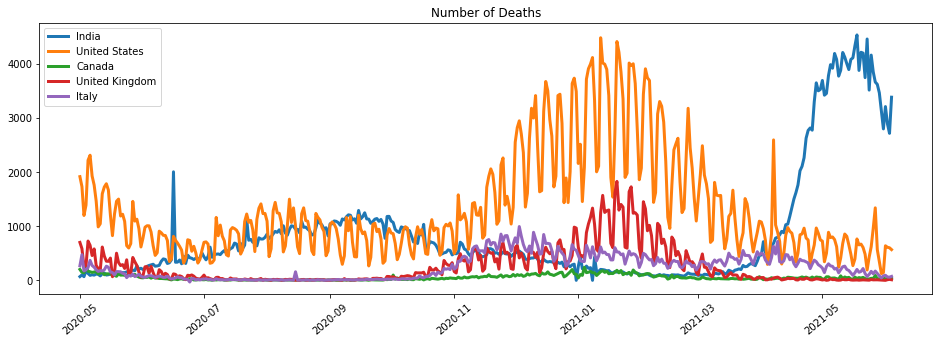

In [51]:
def pltCountry_fatalities(Fatalities, *argv):
  f, ax = plt.subplots(figsize = (16, 5))
  labels = argv
  #print(labels)     #('China',)
  for i in argv:
    #print(i)
    #print(i)       #China
    country = dataset.loc[(dataset["location"] == i)]
    #px.line(country, country["date"], country["new_deaths"], title =  "Number of Deaths (Canada)")

    plt.plot(country["date"], country["new_deaths"], linewidth = 3)
    plt.xticks(rotation = 40)
    plt.legend(labels)
    #px.legend(labels)
    ax.set(title = "Number of Deaths")

pltCountry_fatalities("new_deaths", "India","United States", "Canada", "United Kingdom", "Italy")

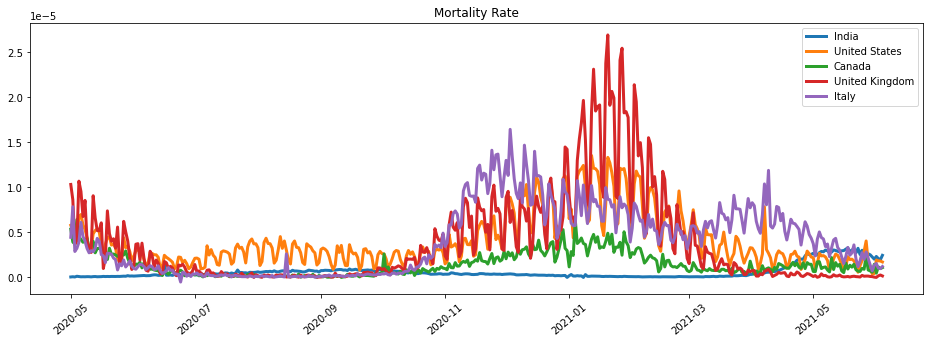

In [52]:
def pltCountry_MortalityRate(Fatalities, *argv):
  f, ax = plt.subplots(figsize = (16, 5))
  labels = argv
  #print(labels)     #('China',)
  for i in argv:
    #print(i)       #China
    country = dataset.loc[(dataset["location"] == i)]
    plt.plot(country["date"], country["Mortality_Rate"], linewidth = 3)
    plt.xticks(rotation = 40)
    plt.legend(labels)
    ax.set(title = "Mortality Rate")

pltCountry_MortalityRate("Mortality_Rate", "India","United States", "Canada", "United Kingdom", "Italy")

In [53]:
 print("OK")

OK


In [54]:
fig = px.line(dataset,  dataset["date"], dataset["Mortality_Rate"], title = "Mortality Rate (5 countries)", color = dataset["location"], hover_data = ["new_deaths", "population", "total_cases", "new_cases"])

In [55]:
px.line(dataset_India,  dataset_India["date"], dataset_India["Mortality_Rate"], title = "Mortality Rate (India)", hover_data = ["new_deaths", "population", "total_cases", "new_cases"])# color = "location" )

In [56]:
#India lockdown ----> 25 March to 31 May'2020

In [57]:
dataset_India2 = df[df["location"] == "India"]

In [58]:
dataset_India2.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
38760,IND,Asia,India,2020-05-01,37257.0,2394.0,1818.143,1223.0,69.0,63.286,26.998,1.735,1.317,0.886,0.050,0.046,1.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72453.0,902654.0,0.654,0.053,51552.0,0.037,0.035,28.4,samples tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.30,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38761,IND,Asia,India,2020-05-02,39699.0,2442.0,1916.571,1323.0,100.0,71.143,28.767,1.770,1.389,0.959,0.072,0.052,1.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73709.0,976363.0,0.708,0.053,56629.0,0.041,0.034,29.5,samples tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.30,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38762,IND,Asia,India,2020-05-03,42505.0,2806.0,2087.857,1391.0,68.0,72.857,30.801,2.033,1.513,1.008,0.049,0.053,1.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70087.0,1046450.0,0.758,0.051,60163.0,0.044,0.035,28.8,samples tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.30,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38763,IND,Asia,India,2020-05-04,46437.0,3932.0,2426.571,1566.0,175.0,89.571,33.650,2.849,1.758,1.135,0.127,0.065,1.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60783.0,1107233.0,0.802,0.044,63059.0,0.046,0.038,26.0,samples tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.94,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645
38764,IND,Asia,India,2020-05-05,49400.0,2963.0,2582.286,1693.0,127.0,97.857,35.797,2.147,1.871,1.227,0.092,0.071,1.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84713.0,1191946.0,0.864,0.061,67888.0,0.049,0.038,26.3,samples tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.94,1.380004e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645


In [59]:
dataset_India2 = dataset_India2[features]

In [60]:
dataset_India2["date"].min()

Timestamp('2020-05-01 00:00:00')

In [61]:
fig = px.line(dataset,  dataset["date"], dataset["Mortality_Rate"], title = "Mortality Rate (5 countries)", color = dataset["location"]) #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()

In [62]:
fig = px.line(dataset,  dataset["date"], dataset["new_deaths"], title = "Daily Deaths (5 countries)", color = dataset["location"]) #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()

In [63]:
fig = px.line(dataset_India,  dataset_India["date"], dataset_India["new_deaths"], title = "Daily Deaths (5 countries)", hover_data = ["population"])#hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines")
fig.update_layout(hovermode = "x unified")
fig.show()

In [64]:
fig = px.bar(dataset_Canada, x = dataset_Canada.index, y = "new_deaths", title = "Daily deaths (Canada)")
fig.update_traces(base = "markers + lines")
fig.update_layout(hovermode = "x unified")
fig.show()

In [65]:
fig = px.bar(dataset_Canada, x = dataset_Canada.index, y = "Mortality_Rate", title = "Martility Rate (Canada)")
fig.update_traces(base = "markers + lines")
fig.update_layout(hovermode = "x unified")
fig.show()

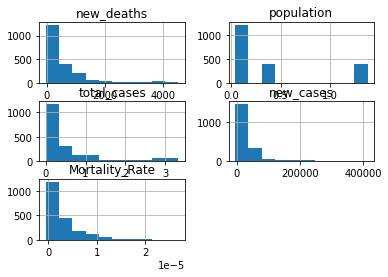

In [66]:
dataset.hist();

In [67]:
feat = ["date", "Mortality_Rate"]

In [68]:
dataset_Canada_MR = dataset_Canada[feat]

In [69]:
dataset_Canada_MR.head()

,date,Mortality_Rate
15216,2020-05-01,0.000005
15217,2020-05-02,0.000004
15218,2020-05-03,0.000004
15219,2020-05-04,0.000006
15220,2020-05-05,0.000005


In [70]:
dataset_Canada_MR.set_index("date", inplace = True)

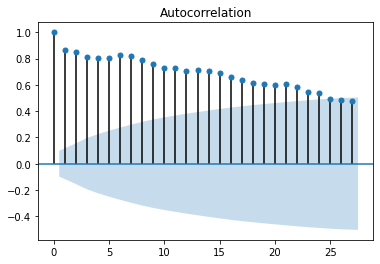

In [71]:
plot_acf(dataset_Canada_MR);

In [72]:
dataset_Canada_MR.head()

,Mortality_Rate
date,
2020-05-01,0.000005
2020-05-02,0.000004
2020-05-03,0.000004
2020-05-04,0.000006
2020-05-05,0.000005


In [73]:
feat = ["date", "new_deaths"]
dataset_Canada_ND = dataset_Canada[feat]

In [74]:
dataset_Canada_ND.set_index("date", inplace = True)

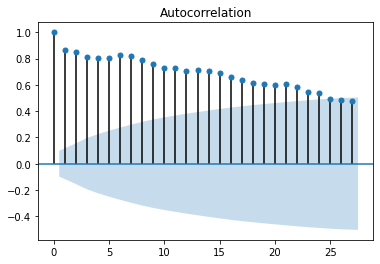

In [75]:
plot_acf(dataset_Canada_MR);

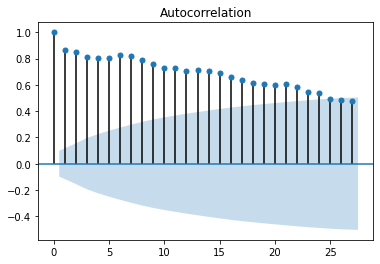

In [76]:
plot_acf(dataset_Canada_ND);

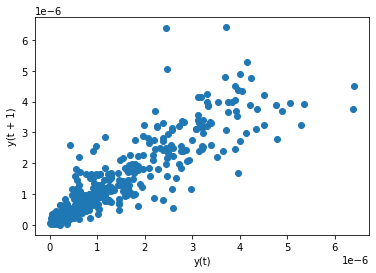

In [77]:
lag_plot(dataset_Canada_MR)

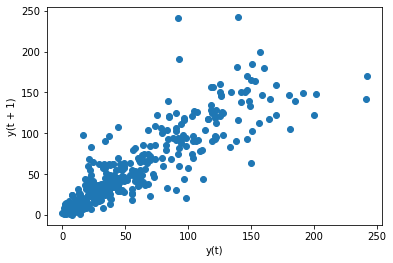

In [78]:
lag_plot(dataset_Canada_ND)

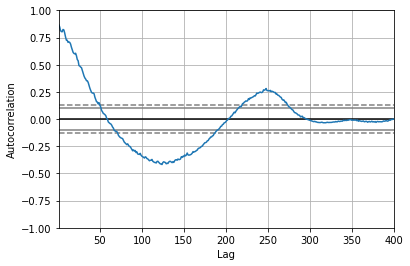

In [79]:
autocorrelation_plot(dataset_Canada_MR)

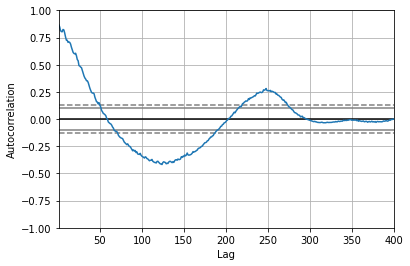

In [80]:
autocorrelation_plot(dataset_Canada_ND)

In [81]:
ten_datesCanadaND = dataset_Canada_ND.tail(10)
ten_datesCanadaMR = dataset_Canada_MR.tail(10)

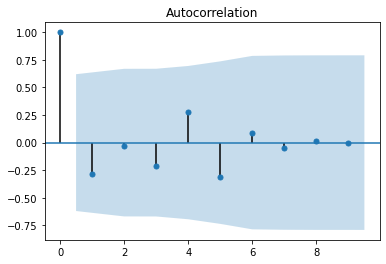

In [82]:
plot_acf(ten_datesCanadaND);

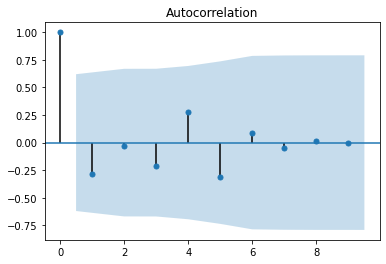

In [83]:
plot_acf(ten_datesCanadaMR);

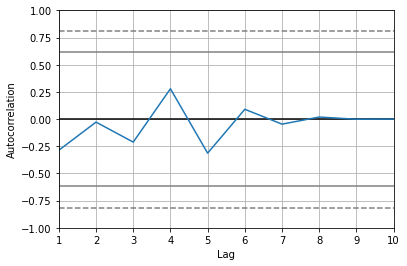

In [84]:
autocorrelation_plot(ten_datesCanadaMR)

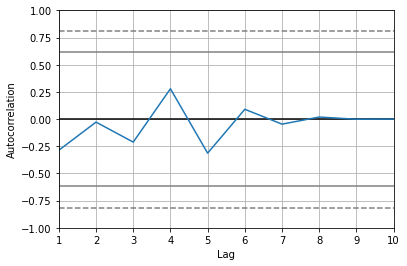

In [85]:
autocorrelation_plot(ten_datesCanadaND)

In [86]:
dataset_Canada.tail()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
15611,2021-05-31,Canada,55.0,37742157.0,1389328.0,2970.0,1.457256e-06
15612,2021-06-01,Canada,18.0,37742157.0,1390979.0,1651.0,4.769203e-07
15613,2021-06-02,Canada,44.0,37742157.0,1393163.0,2184.0,1.165805e-06
15614,2021-06-03,Canada,37.0,37742157.0,1395336.0,2173.0,9.803361e-07
15615,2021-06-04,Canada,41.0,37742157.0,1397370.0,2034.0,1.086318e-06


In [87]:
dataset_UK_date = dataset_UK[dataset_UK["date"] >= "2021-05-23"]
dataset_India_date = dataset_India[dataset_India["date"] >= "2021-05-23"]
dataset_Canada_date = dataset_Canada[dataset_Canada["date"] >= "2021-05-23"]
dataset_USA_date = dataset_USA[dataset_USA["date"] >= "2021-05-23"]
dataset_Italy_date = dataset_Italy[dataset_Italy["date"] >= "2021-05-23"]

In [88]:
feat1 = ["date", "Mortality_Rate"]
feat = ["date", "new_deaths"]

In [89]:
dataset_UK_date_MR = dataset_UK_date[feat1]
dataset_UK_date_ND = dataset_UK_date[feat]

dataset_India_date_MR = dataset_India_date[feat1]
dataset_India_date_ND = dataset_India_date[feat]

dataset_Italy_date_MR = dataset_Italy_date[feat1]
dataset_Italy_date_ND = dataset_Italy_date[feat]

dataset_USA_date_MR = dataset_USA_date[feat1]
dataset_USA_date_ND = dataset_USA_date[feat]

dataset_Canada_date_MR = dataset_Canada_date[feat1]
dataset_Canada_date_ND = dataset_Canada_date[feat]

In [90]:
dataset_UK_date_MR.set_index("date", inplace = True)
dataset_UK_date_ND.set_index("date", inplace = True)

dataset_India_date_MR.set_index("date", inplace = True)
dataset_India_date_ND.set_index("date", inplace = True)

dataset_Canada_date_MR.set_index("date", inplace = True)
dataset_Canada_date_ND.set_index("date", inplace = True)

dataset_Italy_date_MR.set_index("date", inplace = True)
dataset_Italy_date_ND.set_index("date", inplace = True)

dataset_USA_date_MR.set_index("date", inplace = True)
dataset_USA_date_ND.set_index("date", inplace = True)

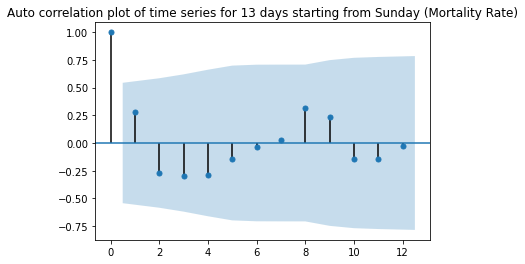

In [91]:
plot_acf(dataset_UK_date_MR, title = "Auto correlation plot of time series for 13 days starting from Sunday (Mortality Rate)");

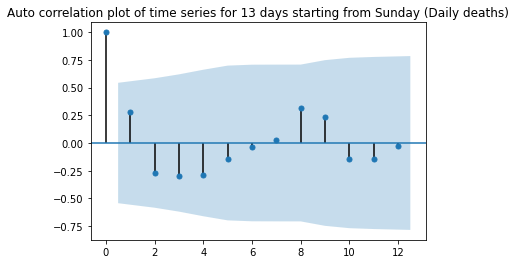

In [92]:
plot_acf(dataset_UK_date_ND, title = "Auto correlation plot of time series for 13 days starting from Sunday (Daily deaths)");

In [93]:
dataset_UK_date = dataset_UK[dataset_UK["date"] >= "2021-05-16"]

In [94]:
dataset_UK_date_MR_20 = dataset_UK_date[feat1]
dataset_UK_date_ND_20 = dataset_UK_date[feat]

In [95]:
dataset_UK_date_MR_20.set_index("date", inplace = True)
dataset_UK_date_ND_20.set_index("date", inplace = True)

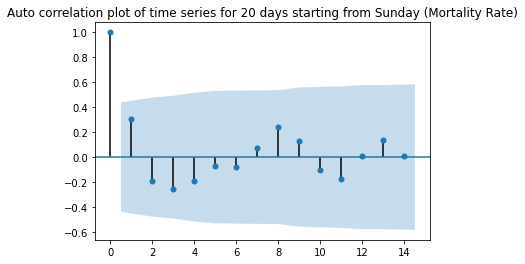

In [96]:
plot_acf(dataset_UK_date_MR_20, title = "Auto correlation plot of time series for 20 days starting from Sunday (Mortality Rate)");

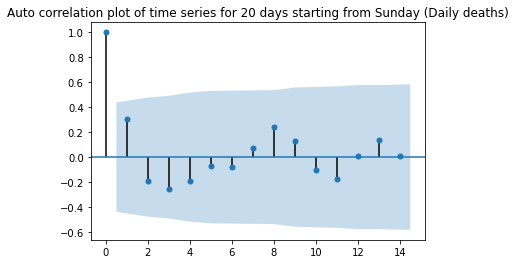

In [97]:
plot_acf(dataset_UK_date_ND_20, title = "Auto correlation plot of time series for 20 days starting from Sunday (Daily deaths)");

In [98]:
dataset_UK_date = dataset_UK[(dataset_UK["date"] >= "2021-05-23") & (dataset_UK["date"] <= "2021-05-29")]

In [99]:
dataset_UK_date

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
88635,2021-05-23,United Kingdom,5.0,67886004.0,4478390.0,2093.0,7.365288e-08
88636,2021-05-24,United Kingdom,3.0,67886004.0,4480760.0,2370.0,4.419173e-08
88637,2021-05-25,United Kingdom,15.0,67886004.0,4483177.0,2417.0,2.209587e-07
88638,2021-05-26,United Kingdom,9.0,67886004.0,4486168.0,2991.0,1.325752e-07
88639,2021-05-27,United Kingdom,10.0,67886004.0,4489552.0,3384.0,1.473058e-07
88640,2021-05-28,United Kingdom,10.0,67886004.0,4493582.0,4030.0,1.473058e-07
88641,2021-05-29,United Kingdom,7.0,67886004.0,4496823.0,3241.0,1.031140e-07


In [100]:
dataset_UK_date_MR_7 = dataset_UK_date[feat1]
dataset_UK_date_ND_7 = dataset_UK_date[feat]

In [101]:
len(dataset_UK_date_MR_7)

7

In [102]:
dataset_UK_date_MR_7.set_index("date", inplace = True)
dataset_UK_date_ND_7.set_index("date", inplace = True)

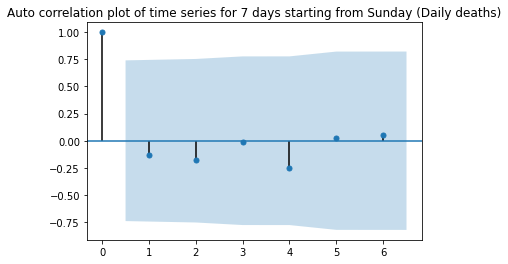

In [103]:
plot_acf(dataset_UK_date_ND_7, title = "Auto correlation plot of time series for 7 days starting from Sunday (Daily deaths)");

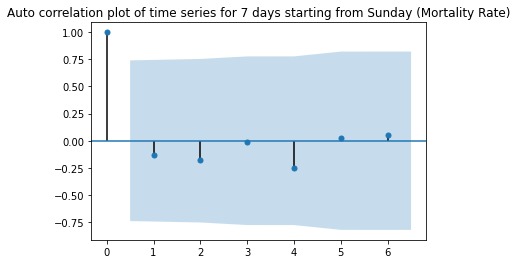

In [104]:
plot_acf(dataset_UK_date_MR_7, title = "Auto correlation plot of time series for 7 days starting from Sunday (Mortality Rate)");

In [105]:
dataset_UK_date = dataset_UK[(dataset_UK["date"] >= "2021-05-16")]

In [106]:
dataset_UK_date_MR_20 = dataset_UK_date[feat1]
dataset_UK_date_ND_20 = dataset_UK_date[feat]

dataset_UK_date_MR_20.set_index("date", inplace = True)
dataset_UK_date_ND_20.set_index("date", inplace = True)

In [107]:
len(dataset_UK_date_MR_20)

20

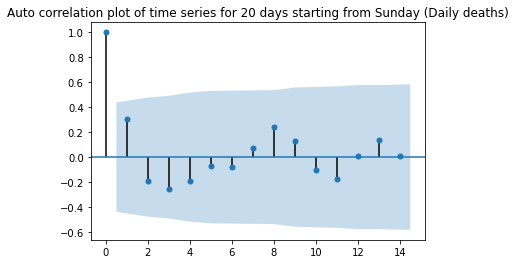

In [108]:
plot_acf(dataset_UK_date_ND_20, title = "Auto correlation plot of time series for 20 days starting from Sunday (Daily deaths)");

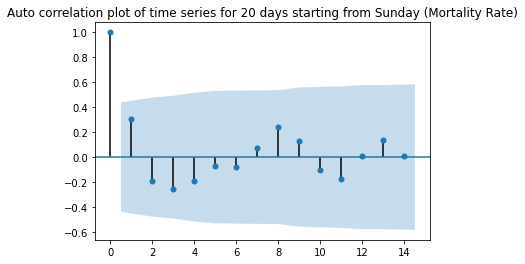

In [109]:
plot_acf(dataset_UK_date_MR_20, title = "Auto correlation plot of time series for 20 days starting from Sunday (Mortality Rate)");

In [110]:
dataset_UK_date_MR = dataset_UK[feat1]
dataset_UK_date_ND = dataset_UK[feat]

In [111]:
dataset_UK_date_MR.set_index("date", inplace = True)
dataset_UK_date_ND.set_index("date", inplace = True)

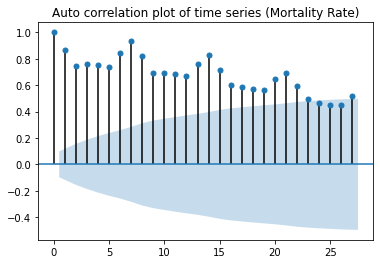

In [112]:
plot_acf(dataset_UK_date_MR, title = "Auto correlation plot of time series (Mortality Rate)");

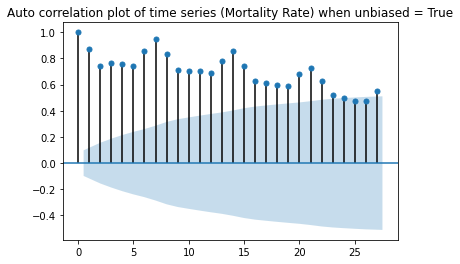

In [113]:
plot_acf(dataset_UK_date_MR, title = "Auto correlation plot of time series (Mortality Rate) when unbiased = True", unbiased = True);

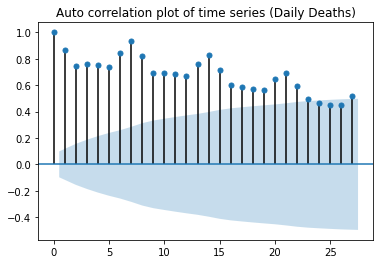

In [114]:
plot_acf(dataset_UK_date_ND, title = "Auto correlation plot of time series (Daily Deaths)", unbiased = False);

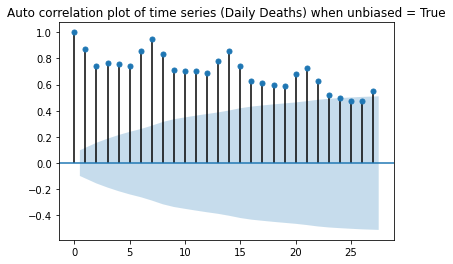

In [115]:
plot_acf(dataset_UK_date_ND, title = "Auto correlation plot of time series (Daily Deaths) when unbiased = True", unbiased = True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5660ddb8d0>]],
      dtype=object)

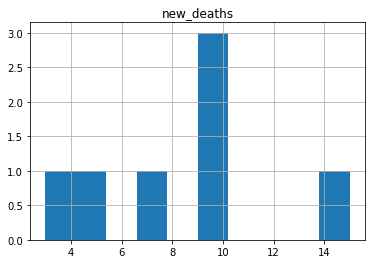

In [116]:
dataset_UK_date_ND_7.hist()

In [117]:
len(dataset_UK_date_ND_7)

7

In [118]:
dataset.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
15216,2020-05-01,Canada,202.0,37742157.0,56343.0,1886.0,0.000005
15217,2020-05-02,Canada,148.0,37742157.0,57926.0,1583.0,0.000004
15218,2020-05-03,Canada,140.0,37742157.0,60504.0,2578.0,0.000004
15219,2020-05-04,Canada,242.0,37742157.0,61957.0,1453.0,0.000006
15220,2020-05-05,Canada,170.0,37742157.0,63215.0,1258.0,0.000005


In [119]:
df = dataset_UK.copy()

In [120]:
df.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
88248,2020-05-01,United Kingdom,700.0,67886004.0,183501.0,4730.0,0.000010
88249,2020-05-02,United Kingdom,585.0,67886004.0,186731.0,3230.0,0.000009
88250,2020-05-03,United Kingdom,253.0,67886004.0,189708.0,2977.0,0.000004
88251,2020-05-04,United Kingdom,273.0,67886004.0,193091.0,3383.0,0.000004
88252,2020-05-05,United Kingdom,725.0,67886004.0,196780.0,3689.0,0.000011


In [121]:
fig = px.histogram(df, x = "date", y = "new_cases", title = "Histogram on Date (UK)")
fig.update_traces(xbins_size = "M1")
fig.update_xaxes(showgrid = True, ticklabelmode = "period", dtick = "M1", tickformat = "%b\n%Y")
fig.update_layout(bargap = 0.1)
fig.add_trace(go.Scatter(mode = "markers", x = df["date"], y = df["new_cases"]))
fig.show()

In [122]:
dataset.head()

,date,location,new_deaths,population,total_cases,new_cases,Mortality_Rate
15216,2020-05-01,Canada,202.0,37742157.0,56343.0,1886.0,0.000005
15217,2020-05-02,Canada,148.0,37742157.0,57926.0,1583.0,0.000004
15218,2020-05-03,Canada,140.0,37742157.0,60504.0,2578.0,0.000004
15219,2020-05-04,Canada,242.0,37742157.0,61957.0,1453.0,0.000006
15220,2020-05-05,Canada,170.0,37742157.0,63215.0,1258.0,0.000005


In [123]:
feat1 = ["date", "location", "Mortality_Rate"]

In [124]:
 dataset_hist = dataset[feat1]

In [125]:
dataset_hist.head()

,date,location,Mortality_Rate
15216,2020-05-01,Canada,0.000005
15217,2020-05-02,Canada,0.000004
15218,2020-05-03,Canada,0.000004
15219,2020-05-04,Canada,0.000006
15220,2020-05-05,Canada,0.000005


In [126]:
fig = px.bar(dataset_hist, x = "date", color = "location",
             y = 'Mortality_Rate',
             title = "Mortalirt Rate Histogram (ALL)",
             barmode = 'group',    #relative, overlay, group        
             height = 600
             #facet_row = "location"
            )

fig.update_traces(base = "markers + lines")
fig.update_layout(hovermode = "x unified")
fig.show()

In [127]:
fig = px.bar(dataset_hist, x = "date", color = "location",
             y = 'Mortality_Rate',
             title = "Mortalirt Rate Histogram (facet_row = location) (ALL)",
             barmode = 'relative',    #relative, overlay, group        
             height = 800,
             facet_row = "location"
            )
fig.update_traces(base = "markers + lines")
fig.update_layout(hovermode = "x unified")
fig.show()

In [128]:
dataset_hist.tail()

,date,location,Mortality_Rate
89143,2021-05-31,United States,4.289996e-07
89144,2021-06-01,United States,1.927477e-06
89145,2021-06-02,United States,1.842886e-06
89146,2021-06-03,United States,1.815695e-06
89147,2021-06-04,United States,1.712977e-06


In [129]:
dataset = dataset_hist.pivot_table("Mortality_Rate", ["date"], "location")

In [130]:
dataset.head()

location,Canada,India,Italy,United Kingdom,United States
date,,,,,
2020-05-01,0.000005,4.999984e-08,0.000004,0.000010,0.000006
2020-05-02,0.000004,7.246354e-08,0.000008,0.000009,0.000005
2020-05-03,0.000004,4.927521e-08,0.000003,0.000004,0.000004
2020-05-04,0.000006,1.268112e-07,0.000003,0.000004,0.000004
2020-05-05,0.000005,9.202869e-08,0.000004,0.000011,0.000007


In [131]:
dataset_Canada = dataset["Canada"]
dataset_India = dataset["India"]
dataset_Italy = dataset["Italy"]
dataset_UK = dataset["United Kingdom"]
dataset_USA = dataset["United States"]

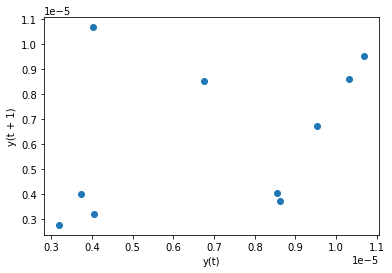

In [132]:
lag_plot(dataset_UK[0 : 11])

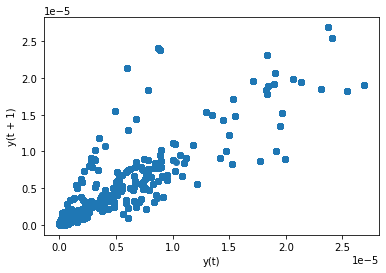

In [133]:
for i in range(len(dataset_UK)):
  lag_plot(dataset_UK[i : i + 11])
  i = i + 20

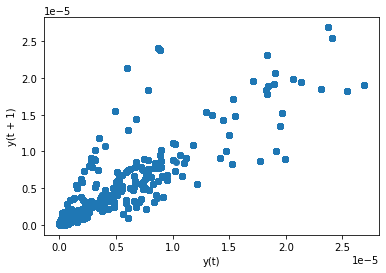

In [134]:
for i in range(len(dataset_UK)):
  lag_plot(dataset_UK[i : i + 21], lag = 1)

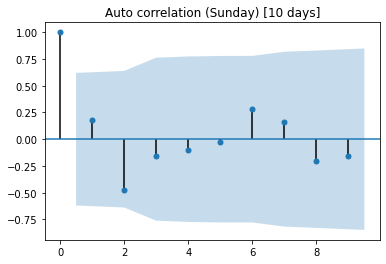

In [135]:
plot_acf(dataset_UK[ : 10], title = "Auto correlation (Sunday) [10 days]");    #This is starting from sunday (10 days)

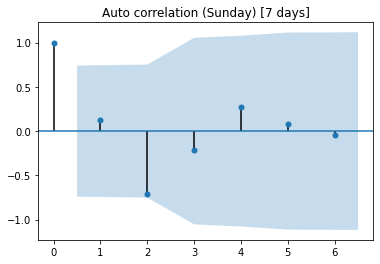

In [136]:
plot_acf(dataset_UK[ : 7], title = "Auto correlation (Sunday) [7 days]");    #This is starting from sunday (7 days)

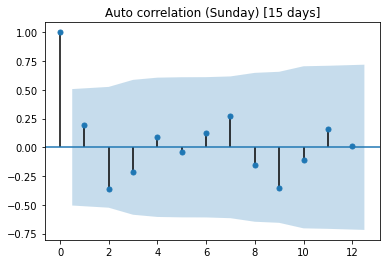

In [137]:
plot_acf(dataset_UK[ : 15], title = "Auto correlation (Sunday) [15 days]");    #This is starting from sunday (15 days)

In [138]:
type(dataset_UK)

pandas.core.series.Series

In [139]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])    #P-valus is almost equal to 0.05, hence the data is stationary
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(dataset_UK)

1. ADF :  -2.855916669729544
2. P-Value :  0.050719693443712195
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 384
5. Critical Values :
	 1% :  -3.4474946672686824
	 5% :  -2.8690962436986855
	 10% :  -2.570795299750434


Text(0, 0.5, 'Mortality Rate')

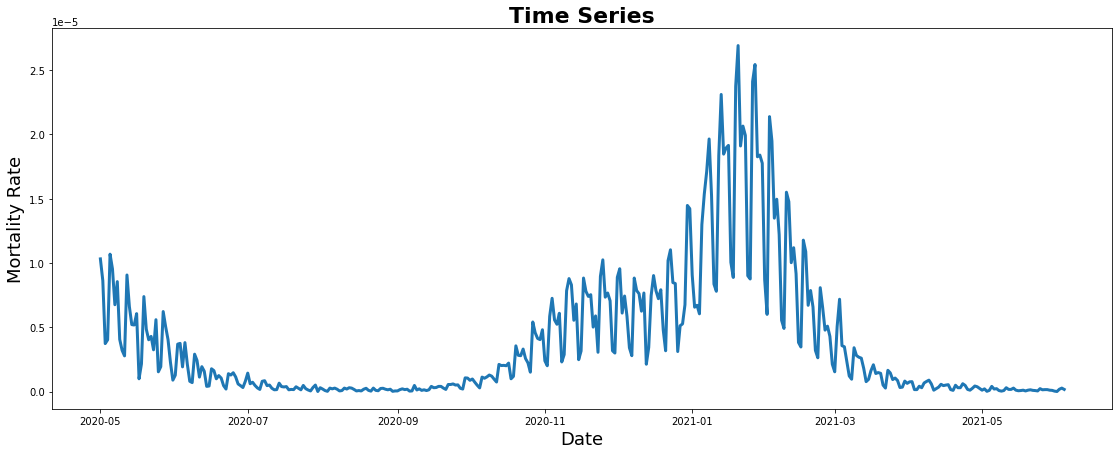

In [140]:
fig = plt.figure(figsize = (19, 7))
plt.plot(dataset_UK, linewidth = 3)
plt.title("Time Series", fontsize = 22, fontweight = "bold")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Mortality Rate", fontsize = 18)

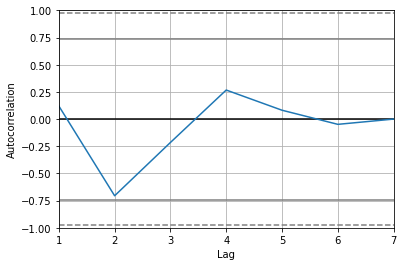

In [141]:
autocorrelation_plot(dataset_UK[ : 7]);

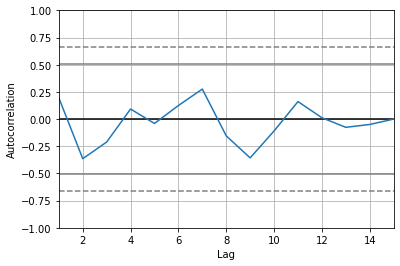

In [142]:
autocorrelation_plot(dataset_UK[ : 15]);

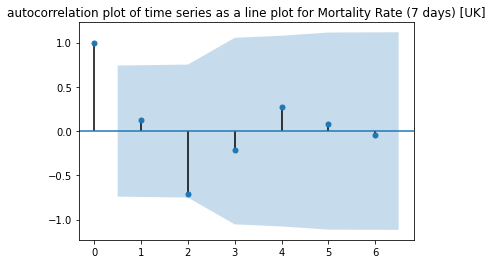

In [143]:
#autocorrelation plot of time series as a line plot for Mortality Rate
plot_acf(dataset_UK[ : 7], title = "autocorrelation plot of time series as a line plot for Mortality Rate (7 days) [UK]");

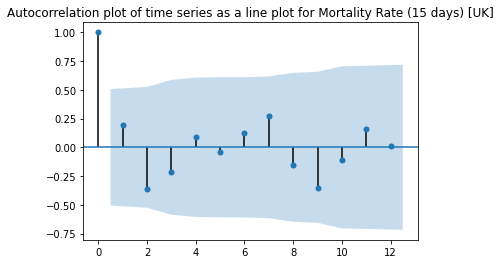

In [144]:
#autocorrelation plot of time series as a line plot for Mortality Rate
plot_acf(dataset_UK[ : 15], title = "Autocorrelation plot of time series as a line plot for Mortality Rate (15 days) [UK]");

In [145]:
df = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")

df = df[df["date"] > "2020-04-30"]

dataset_UK = df[df["location"] == "United Kingdom"]  

In [146]:
dataset_UK["Mortality_Rate"] = " "

In [147]:
dataset_UK["Mortality_Rate"] = dataset_UK["new_deaths"]/dataset_UK["population"]

In [148]:
dataset_UK.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Mortality_Rate
88248,GBR,Europe,United Kingdom,2020-05-01,183501.0,4730.0,4544.571,27454.0,700.0,654.429,2703.076,69.676,66.944,404.413,10.311,9.640,0.94,2178.0,32.083,14723.0,216.878,NaN,NaN,NaN,NaN,74142.0,996826.0,14.684,1.092,51787.0,0.763,0.088,11.4,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.000010
88249,GBR,Europe,United Kingdom,2020-05-02,186731.0,3230.0,4468.286,28039.0,585.0,621.429,2750.655,47.580,65.820,413.031,8.617,9.154,0.91,2068.0,30.463,14380.0,211.826,NaN,NaN,NaN,NaN,63559.0,1060387.0,15.620,0.936,56716.0,0.835,0.079,12.7,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.000009
88250,GBR,Europe,United Kingdom,2020-05-03,189708.0,2977.0,4397.429,28292.0,253.0,605.571,2794.508,43.853,64.777,416.757,3.727,8.920,0.87,2009.0,29.594,14188.0,208.997,NaN,NaN,9617.0,141.664,68203.0,1128590.0,16.625,1.005,61943.0,0.912,0.071,14.1,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.000004
88251,GBR,Europe,United Kingdom,2020-05-04,193091.0,3383.0,4208.714,28565.0,273.0,598.429,2844.342,49.834,61.997,420.779,4.021,8.815,0.82,1936.0,28.518,14097.0,207.657,NaN,NaN,NaN,NaN,72630.0,1208190.0,17.797,1.070,68805.0,1.014,0.061,16.3,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.000004
88252,GBR,Europe,United Kingdom,2020-05-05,196780.0,3689.0,4060.429,29290.0,725.0,563.286,2898.683,54.341,59.812,431.459,10.680,8.298,0.80,1874.0,27.605,13723.0,202.148,NaN,NaN,NaN,NaN,66919.0,1270344.0,18.713,0.986,71218.0,1.049,0.057,17.5,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.000011


In [149]:
features = ["date", "Mortality_Rate"]

In [150]:
dataset_UK = dataset_UK[features]

In [151]:
def split(ts):
  size = int(len(ts) * 0.85)
  train = ts[ : size]
  test = ts[size : ]
  return (train, test)

tscc = dataset_UK["Mortality_Rate"].values
traincc, testcc = split(tscc)

In [152]:
#train autoregression for Mortality Rate

predictions = []
model = AR(traincc)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [153]:
#walk forward over time steps in test

history = traincc[len(traincc)-window:]
history = [history[i] for i in range(len(history))]
predictions = []

for t in range(len(testcc)):
  length = len(history)
  lag = [history[i] for i in range(length-window, length)]
  yhat = coef[0]

  for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
  obs = testcc[t]
  predictions.append(yhat)
  history.append(obs)

  #print("Predicted = %f, expected = %f" % (yhat, obs))

RMSE_arcc = sqrt(mean_squared_error(y_true = testcc, y_pred = predictions))

In [154]:
RMSE_arcc

2.1856385989209834e-07

In [155]:
rmsecc = []

print('Test RMSE: %.3f' % RMSE_arcc)
rmsecc.append(RMSE_arcc)

Test RMSE: 0.000


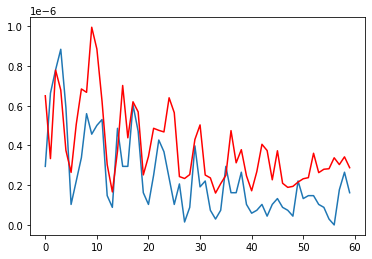

In [156]:
# plot

plt.plot(testcc)
plt.plot(predictions, color = 'red')     #this is not clear to me (doubts in it)

In [157]:
stepwise_fit = auto_arima(traincc, trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7290.273, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7307.979, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7306.101, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7305.066, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7669.528, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7232.243, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.262 seconds


In [158]:
def mape(y2, y_pred):
  return sqrt(mean_squared_error(y_true = y2, y_pred = y_pred))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  340
Model:                     ARMA(5, 5)   Log Likelihood                4101.806
Method:                       css-mle   S.D. of innovations              0.000
Date:                Fri, 11 Jun 2021   AIC                          -8179.613
Time:                        05:05:11   BIC                          -8133.665
Sample:                             0   HQIC                         -8161.305
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.432e-06   5.43e-06      0.817      0.414    -6.2e-06    1.51e-05
ar.L1.y        1.8303      0.031     59.980      0.000       1.770       1.890
ar.L2.y       -2.2496      0.060    -37.422      0.0

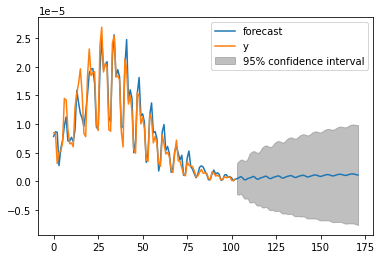

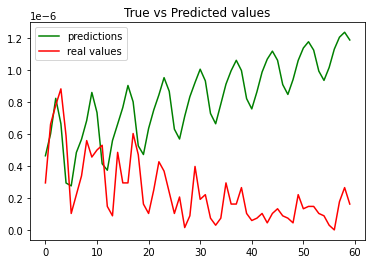

In [159]:
#Arima modeling for ts
def arima(ts,test):
    p = d = q = range(0,6)
    a = 99999
    pdq = list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic <= a) :
                a = result.aic
                param = var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order = param)
    result = model.fit()
    result.plot_predict(start = int(len(ts) * 0.7), end = int(len(ts) * 1.2))
    pred = result.forecast(steps = len(test))[0]
    
    #Plotting results
    f,ax = plt.subplots()
    plt.plot(pred, c = 'green', label = 'predictions')
    plt.plot(test, c = 'red',label = 'real values')
    plt.legend()
    plt.title('True vs Predicted values')
    
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean squared error: %f'%mape(test,pred))
    return pred

pred = arima(traincc, testcc)
RMSE_arimacc = sqrt(mean_squared_error(y_true = testcc, y_pred = pred))
rmsecc.append(RMSE_arimacc)